# Poisson Regression for Competiton

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels
from patsy import dmatrices
plt.style.use(['ggplot'])

In [2]:
# load the dataset
PATH = '/Users/dj/Documents/GitHub/Data/ts_forecast'
df = pd.read_csv( PATH + '/df.csv') # Training data 
df1 = pd.read_csv( PATH + '/df1.csv') # Testing data
df2 = pd.read_csv( PATH + '/df2.csv') # Complete data for Competition
reduced = pd.read_csv( PATH + '/reduced.csv') #Only last month
print(df.dtypes) # We can see that month is of type object, therefore it will be changed to datetime

Unnamed: 0     int64
d             object
date          object
weekday       object
id            object
sales          int64
dtype: object


In [3]:
# For some strange reason, a new column is being added which will be removed 
df = df.drop(['Unnamed: 0'], axis=1)
df1 = df1.drop(['Unnamed: 0'], axis=1)
df2 = df2.drop(['Unnamed: 0'], axis=1)
reduced = reduced.drop(['Unnamed: 0'], axis=1)

In [71]:
# Change the type object of date to date
df['date'] = pd.to_datetime(df['date'])
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
reduced['date'] = pd.to_datetime(reduced['date'])

print(df1.dtypes)

d                  object
date       datetime64[ns]
weekday            object
id                 object
sales               int64
dtype: object


In [5]:
df = df.sort_values(by = ['id', 'date'])
df1 = df1.sort_values(by = ['id', 'date'])
df2 = df2.sort_values(by = ['id', 'date'])
reduced = reduced.sort_values(by = ['id', 'date'])
df

,d,date,weekday,id,sales
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0
...,...,...,...,...,...
1570833,d_1909,2016-04-20,Wednesday,FOODS_3_827_TX_3_validation,0
1571482,d_1910,2016-04-21,Thursday,FOODS_3_827_TX_3_validation,1
1572453,d_1911,2016-04-22,Friday,FOODS_3_827_TX_3_validation,0
1573305,d_1912,2016-04-23,Saturday,FOODS_3_827_TX_3_validation,0


# End of Data Import - Let's do EDA

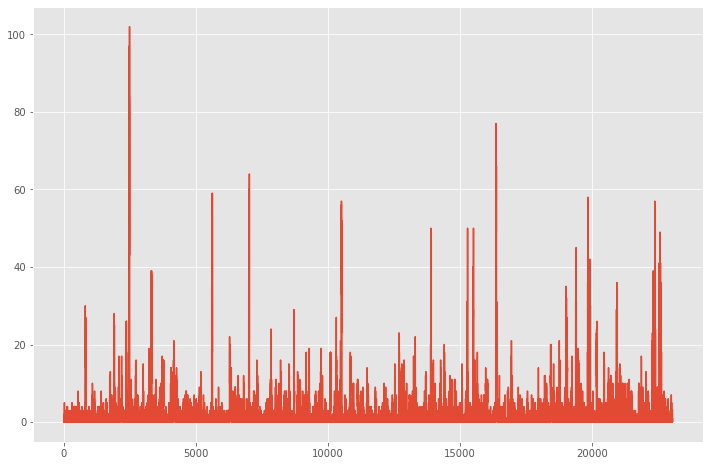

In [5]:
plt.figure(figsize=(12,8))
plt.plot(reduced["sales"])

# Creating a SMALL DATAFRAME frame for testing purposes 


In [29]:
names = np.unique(df['id'])
selected = names[0:4]

small_df = df[df['id'].isin(selected)]
small_df = small_df.sort_values(by = ['id', 'date'])

In [30]:
small_ds = small_df['date']
small_df['MONTH'] = small_ds.dt.month
small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
small_df['DAY'] = small_ds.dt.day

small_df

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0,1,5,29
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2,1,6,30
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1,1,0,31
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3,2,1,1
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0,2,2,2
...,...,...,...,...,...,...,...,...
1570374,d_1909,2016-04-20,Wednesday,FOODS_3_004_TX_3_validation,0,4,2,20
1571470,d_1910,2016-04-21,Thursday,FOODS_3_004_TX_3_validation,0,4,3,21
1572200,d_1911,2016-04-22,Friday,FOODS_3_004_TX_3_validation,0,4,4,22
1572928,d_1912,2016-04-23,Saturday,FOODS_3_004_TX_3_validation,0,4,5,23


In [31]:
piv_tab = small_df.pivot_table(index='date',columns='id',values='sales',aggfunc='sum')

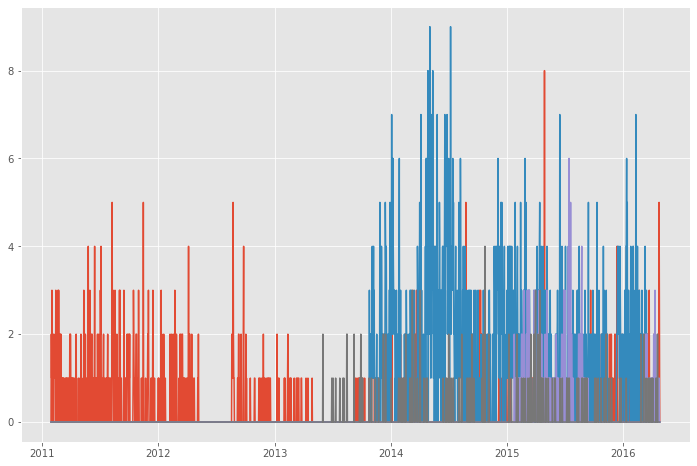

In [32]:
plt.figure(figsize=(12,8))
plt.plot(piv_tab)
plt.show()

In [33]:
small_r = df1[df1['id'].isin(selected)]
small_r = small_r.sort_values(by = ['id', 'date'])
small_r

,d,date,weekday,id,sales
0,d_1914,2016-04-25,Monday,FOODS_3_001_TX_3_validation,1
1094,d_1915,2016-04-26,Tuesday,FOODS_3_001_TX_3_validation,0
2188,d_1916,2016-04-27,Wednesday,FOODS_3_001_TX_3_validation,0
3282,d_1917,2016-04-28,Thursday,FOODS_3_001_TX_3_validation,1
3310,d_1918,2016-04-29,Friday,FOODS_3_001_TX_3_validation,0
...,...,...,...,...,...
18961,d_1937,2016-05-18,Wednesday,FOODS_3_004_TX_3_validation,0
19788,d_1938,2016-05-19,Thursday,FOODS_3_004_TX_3_validation,0
20593,d_1939,2016-05-20,Friday,FOODS_3_004_TX_3_validation,0
21419,d_1940,2016-05-21,Saturday,FOODS_3_004_TX_3_validation,1


# Transition to Poisson Regression

In [83]:
# Getting some additional data for the regression
ds = df['date']
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day


ds1 = df1['date']
df1['MONTH'] = ds.dt.month
df1['DAY_OF_WEEK'] = ds1.dt.dayofweek
df1['DAY'] = ds1.dt.day

ds2 = df2['date']
df2['MONTH'] = ds2.dt.month
df2['DAY_OF_WEEK'] = ds2.dt.dayofweek
df2['DAY'] = ds2.dt.day

rds = reduced['date']
reduced['MONTH'] = rds.dt.month
reduced['DAY_OF_WEEK'] = rds.dt.dayofweek
reduced['DAY'] = rds.dt.day

In [77]:
small_r

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
28,d_1914,2016-04-25,Monday,FOODS_3_002_TX_3_validation,0,4,0,25
1122,d_1915,2016-04-26,Tuesday,FOODS_3_002_TX_3_validation,0,4,1,26
2216,d_1916,2016-04-27,Wednesday,FOODS_3_002_TX_3_validation,0,4,2,27
3289,d_1917,2016-04-28,Thursday,FOODS_3_002_TX_3_validation,0,4,3,28
3312,d_1918,2016-04-29,Friday,FOODS_3_002_TX_3_validation,0,4,4,29
4406,d_1919,2016-04-30,Saturday,FOODS_3_002_TX_3_validation,0,4,5,30
5500,d_1920,2016-05-01,Sunday,FOODS_3_002_TX_3_validation,0,5,6,1
6577,d_1921,2016-05-02,Monday,FOODS_3_002_TX_3_validation,0,5,0,2
6596,d_1922,2016-05-03,Tuesday,FOODS_3_002_TX_3_validation,0,5,1,3
7690,d_1923,2016-05-04,Wednesday,FOODS_3_002_TX_3_validation,2,5,2,4


# Poisson Regression 

In [98]:
# old way
#mask = np.random.rand(len(small_df)) < 0.8
#df_train = small_df[mask]
#df_test = small_df[~mask]

# New way

df_train = small_df
df_test = small_r
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=1913
Testing data set length=28


In [99]:
expr = """sales ~ DAY +  MONTH + weekday"""

In [100]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [101]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [102]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sales   No. Observations:                 1913
Model:                            GLM   Df Residuals:                     1904
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1467.9
Date:                Sat, 11 Dec 2021   Deviance:                       1969.7
Time:                        14:41:42   Pearson chi2:                 2.97e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02903
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.0381 

In [103]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
0      0.311514  0.041645       0.239708       0.404829
1094   0.532803  0.061277       0.425275       0.667517
2188   0.183507  0.030300       0.132771       0.253630
3282   0.312130  0.041447       0.240606       0.404915
3310   0.318651  0.042694       0.245058       0.414346
4378   0.294459  0.040949       0.224209       0.386722
5472   0.451029  0.056227       0.353258       0.575862
6566   0.326747  0.044405       0.250341       0.426471
6594   0.558856  0.062894       0.448234       0.696778
7662   0.192480  0.030944       0.140456       0.263773
8756   0.331981  0.042842       0.257790       0.427523
9850   0.338917  0.042731       0.264712       0.433923
9878   0.313186  0.040225       0.243487       0.402838
10946  0.442645  0.049277       0.355874       0.550572
12040  0.320672  0.040037       0.251065       0.409578
13134  0.548466  0.055222       0.450243       0.668117
13189  0.188901  0.029007       0.139807       0

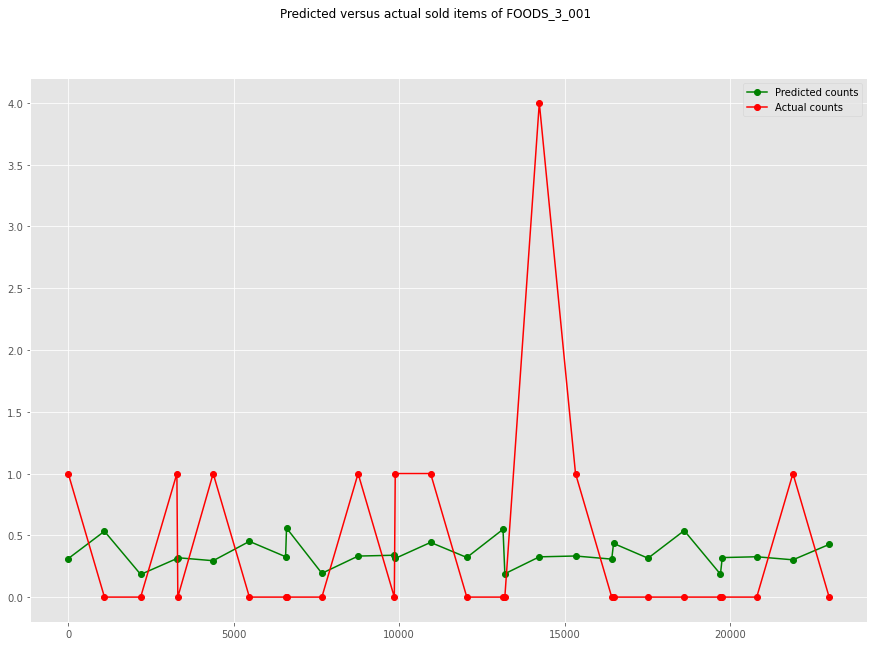

In [104]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['sales']
fig = plt.figure(figsize=(15,10))
fig.suptitle('Predicted versus actual sold items of FOODS_3_001')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()


<Figure size 432x288 with 0 Axes>

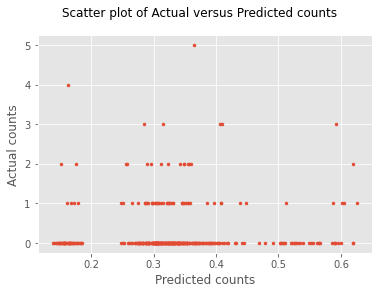

In [17]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [18]:
np.mean(y_test['sales'])

0.28184281842818426

In [38]:
pred = predictions_summary_frame['mean']
print(len(pred))
print(len(y_test))
test = np.array(y_test).reshape(369,).shape

369
369


In [40]:
rmse = statsmodels.tools.eval_measures.rmse(pred, test, axis = 0)

In [62]:
rmse

368.6706400890091

In [92]:
print(df.shape)
print(df1.shape)
print(df2.shape)
print(reduced.shape)

(1574399, 9)
(23044, 9)
(1597443, 9)
(23044, 9)


# FOR LOOP FOR MULTIVARIATE FORECAST

In [66]:
names = np.unique(df['id'])

f = []
for i in np.arange(1,29):
    f.append('F' + str(i))

r = np.arange(28)

z = pd.Series(np.zeros(28))

d = {'mean': z}
forecasts = pd.DataFrame(d)

In [90]:
# get data ready
selected = names[0:3]
# zip_object = zip(selected, r)

for i in names[0:2]:

    print(i)

    small_df = df[df['id'].isin([i])]
    small_df = small_df.sort_values(by = ['id', 'date'])


    small_r = df1[df1['id'].isin([i])]
    small_r = small_r.sort_values(by = ['id', 'date'])

    #if i == 'FOODS_3_002_TX_3_validation':
    #    print(small_r)
    

    small_ds = small_df['date']
    small_df['MONTH'] = small_ds.dt.month
    small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
    small_df['DAY'] = small_ds.dt.day

    small_dsr = small_r['date']
    small_r['MONTH'] = small_dsr.dt.month
    small_r['DAY_OF_WEEK'] = small_dsr.dt.dayofweek
    small_r['DAY'] = small_dsr.dt.day

    # Begin Regression
    expr = """sales ~ DAY +  MONTH + weekday"""

    df_train = small_df
    df_test = small_r
    if i == 'FOODS_3_002_TX_3_validation':
        print(small_df)

    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

    

    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    #summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    p = predictions_summary_frame['mean']
    forecasts[i] = p

FOODS_3_001_TX_3_validation
FOODS_3_002_TX_3_validation
              d       date    weekday                           id  sales  \
456         d_1 2011-01-29   Saturday  FOODS_3_002_TX_3_validation      0   
1185        d_2 2011-01-30     Sunday  FOODS_3_002_TX_3_validation      0   
1794        d_3 2011-01-31     Monday  FOODS_3_002_TX_3_validation      0   
2686        d_4 2011-02-01    Tuesday  FOODS_3_002_TX_3_validation      0   
3346        d_5 2011-02-02  Wednesday  FOODS_3_002_TX_3_validation      0   
...         ...        ...        ...                          ...    ...   
1570802  d_1909 2016-04-20  Wednesday  FOODS_3_002_TX_3_validation      0   
1571775  d_1910 2016-04-21   Thursday  FOODS_3_002_TX_3_validation      0   
1572505  d_1911 2016-04-22     Friday  FOODS_3_002_TX_3_validation      0   
1572991  d_1912 2016-04-23   Saturday  FOODS_3_002_TX_3_validation      0   
1574085  d_1913 2016-04-24     Sunday  FOODS_3_002_TX_3_validation      0   

         MONTH  DAY

In [80]:
forecasts

,mean,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation
0,0.0,0.298776,NaN
1,0.0,NaN,NaN
2,0.0,NaN,NaN
3,0.0,NaN,NaN
4,0.0,NaN,NaN
5,0.0,NaN,NaN
6,0.0,NaN,NaN
7,0.0,NaN,NaN
8,0.0,NaN,NaN
9,0.0,NaN,NaN


In [65]:
forecasts = forecasts.drop(['mean'], axis=1)

In [301]:
# forecasts.set_index('F')

In [302]:
competition = forecasts.T

In [303]:
competition.columns = f

In [304]:
competition

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
FOODS_3_001_TX_3_validation,0.300536,0.514026,0.177040,0.305351,0.334061,0.308699,0.436303,0.316078,0.540609,0.186195,...,0.321756,0.297329,0.420232,0.304435,0.520695,0.179337,0.309312,0.315775,0.291801,0.412420
FOODS_3_002_TX_3_validation,0.759305,0.627168,0.639500,0.530341,0.777787,0.945714,0.998832,1.000642,0.826506,0.842758,...,0.655640,0.797195,0.841971,0.843497,0.696708,0.710408,0.589146,0.601960,0.731926,0.773036
FOODS_3_003_TX_3_validation,0.162369,0.167178,0.156165,0.165870,0.117817,0.145424,0.210480,0.146017,0.150342,0.140438,...,0.114672,0.141543,0.204861,0.142119,0.146329,0.136690,0.145184,0.113131,0.139641,0.202109
FOODS_3_004_TX_3_validation,0.048995,0.093120,0.066568,0.062619,0.093032,0.146639,0.112784,0.067102,0.127536,0.091171,...,0.076573,0.120697,0.092831,0.055231,0.104973,0.075041,0.070589,0.069470,0.109501,0.084220
FOODS_3_005_TX_3_validation,0.744305,0.618908,0.544840,0.601631,0.793678,0.991349,0.943322,0.954043,0.793310,0.698371,...,0.688152,0.859542,0.817900,0.827195,0.687833,0.605517,0.668632,0.640774,0.800363,0.761589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_TX_3_validation,0.143198,0.126709,0.142208,0.117147,0.268556,0.276620,0.328938,0.239400,0.211834,0.237745,...,0.200749,0.206777,0.245886,0.178955,0.158349,0.177718,0.146399,0.173566,0.178777,0.212590
FOODS_3_824_TX_3_validation,0.202251,0.226814,0.190488,0.218980,0.229073,0.308471,0.270679,0.191705,0.214987,0.180555,...,0.232713,0.313372,0.274980,0.194751,0.218403,0.183423,0.210859,0.234554,0.315852,0.277155
FOODS_3_825_TX_3_validation,0.677015,0.576109,0.468775,0.521788,0.635221,0.873682,0.881170,0.842432,0.716871,0.583312,...,0.551869,0.759039,0.765544,0.731890,0.622804,0.506771,0.564081,0.514388,0.707488,0.713552
FOODS_3_826_TX_3_validation,0.567105,0.641129,0.620160,0.607182,0.641478,0.734234,0.677009,0.571385,0.645967,0.624840,...,0.627214,0.717907,0.661955,0.558679,0.631603,0.610946,0.598160,0.620201,0.709881,0.654554


In [251]:
competition.to_csv(PATH + '/poisson_pred.csv', index=True)

In [45]:
df[df['id'].isin(['FOODS_3_023_TX_3_validation'])]

,d,date,weekday,id,sales
171,d_1,2011-01-29,Saturday,FOODS_3_023_TX_3_validation,1
1021,d_2,2011-01-30,Sunday,FOODS_3_023_TX_3_validation,2
2280,d_3,2011-01-31,Monday,FOODS_3_023_TX_3_validation,0
2725,d_4,2011-02-01,Tuesday,FOODS_3_023_TX_3_validation,2
3902,d_5,2011-02-02,Wednesday,FOODS_3_023_TX_3_validation,0
...,...,...,...,...,...
1570880,d_1909,2016-04-20,Wednesday,FOODS_3_023_TX_3_validation,0
1571488,d_1910,2016-04-21,Thursday,FOODS_3_023_TX_3_validation,1
1572096,d_1911,2016-04-22,Friday,FOODS_3_023_TX_3_validation,1
1572866,d_1912,2016-04-23,Saturday,FOODS_3_023_TX_3_validation,0


In [158]:
selected = names[0:3]
zip_object = zip(selected, f)

for i,j in zip_object:
    print(i,j)

FOODS_3_001_TX_3_validation F1
FOODS_3_002_TX_3_validation F2
FOODS_3_003_TX_3_validation F3


# RMSE for paper

In [ ]:
names = np.unique(df['id'])

f = []
for i in np.arange(1,29):
    f.append('F' + str(i))

r = np.arange(28)

z = pd.Series(np.zeros(28))

d = {'mean': z}
forecasts = pd.DataFrame(d)

In [ ]:
# get data ready
selected = names[0:5]
# zip_object = zip(selected, r)

for i in names:

    small_df = df[df['id'].isin([i])]
    small_df = small_df.sort_values(by = ['id', 'date'])

    small_r = reduced[reduced['id'].isin(selected)]
    small_r = small_r.sort_values(by = ['id', 'date'])

    small_ds = small_df['date']
    small_df['MONTH'] = small_ds.dt.month
    small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
    small_df['DAY'] = small_ds.dt.day

    small_dsr = small_r['date']
    small_r['MONTH'] = small_dsr.dt.month
    small_r['DAY_OF_WEEK'] = small_dsr.dt.dayofweek
    small_r['DAY'] = small_dsr.dt.day

    # Begin Regression
    expr = """sales ~ DAY +  MONTH + weekday"""

    y_train, X_train = dmatrices(expr, small_df, return_type='dataframe')
    y_test, X_test = dmatrices(expr, small_r, return_type='dataframe')

    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    #summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    p = predictions_summary_frame['mean']
    forecasts[i] = p